### 1.Importing Required Libraries for NLP & ML Project

In [1]:
# ===============================
# Basic Libraries
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

# ===============================
# Utilities & Helpers
# ===============================
import re
import string
import random
from itertools import product
import warnings
warnings.filterwarnings("ignore")

# ===============================
# Data Balancing & Processing
# ===============================
from imblearn.over_sampling import SMOTE, RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

# ===============================
# NLP (Natural Language Processing)
# ===============================
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# ===============================
# Feature Extraction
# ===============================
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# ===============================
# Model Training & Selection
# ===============================
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

# ===============================
# Machine Learning Models
# ===============================
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# ===============================
# Evaluation Metrics
# ===============================
from sklearn.metrics import (
    f1_score, accuracy_score, classification_report,
    confusion_matrix, roc_curve, auc
)

# ===============================
# Data Handling
# ===============================
from sklearn.utils import shuffle


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PMLS/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\PMLS/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#load the data
df = pd.read_csv('Combined Data.csv', index_col=0)

In [3]:
#Drop NULLs
df.dropna(inplace = True)

In [4]:
df.shape

(52681, 2)

In [5]:
df.describe().T

count unique                top   freq
statement  52681  51073  what do you mean?     22
status     52681      7             Normal  16343

In [6]:
#As we are going to do binary classifications here, turn all mentl health issues to '1' and normal to 0
df['status'] = df['status'].apply(lambda x: 1 if x != "Normal" else 0)

After bacis cleaning dropping the NULLs, the data contains 52681 records with 2 columns, statement \(text\) and status \(status\) .
There are 7 unique status, as we are going to do binary classification here, we turn all mentl health issues to '1' and normal to 0

## Classical ML Models


### Pre-processing for classical ML Models

In [7]:
#make a copy of data especially for classical ML Models
df1 = df.copy()

In [8]:
# Step 1: Clean the Text
# Purpose: Removes noise (e.g., special characters, extra spaces) that doesn't contribute to understanding the text's meaning.
def clean_text(text):
    """Cleans input text from social media for NLP models.

    Args:
        text (str): The input text.

    Returns:
        str: The cleaned text.
    """
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#\w+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df1['statement'] = df1['statement'].apply(clean_text)

In [9]:
#Step 2: stopwords removal
#Stop words (e.g., "and", "is", "the") do not carry much meaning and can be removed to reduce noise.
stop_words = set(stopwords.words('english'))
df1['statement'] = df1['statement'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [10]:
#Step 3：lemmatize
# Reduces words to their base or root forms, ensuring that variations of the same word are treated equally (e.g., "running", "runs", "ran" → "run").
lemmatizer = WordNetLemmatizer()
df1['statement'] = df1['statement'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


In [11]:
#Step 4: Train-Test Split
#Random sample with seed, use 20% data for test, 60% data for train,20% data for validation
X1 = df1['statement']
y1 = df1['status']

# Initial train-test split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X1.tolist(), y1.tolist(), test_size=0.2, random_state=42
)

# Further split training data into training and validation sets
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(
    X_train_1, y_train_1, test_size=0.25, random_state=42  # for validation: 0.25 * 0.8 = 0.2 of original data
)


In [12]:
# Step 5: TF-IDF Vectorization
#Converts raw text into numerical features for input to ML models
import joblib
tfidf = joblib.load("Models/tfidf_vectorizer_1_binary.pkl")
X_train_tfidf_1 = tfidf.transform(X_train_1)  # Fit on training data
X_test_tfidf_1 = tfidf.transform(X_test_1)       # Transform test data

# Initialize the TF-IDF Vectorizer
tfidf = tfidf = joblib.load("Models/tfidf_vectorizer_2_binary.pkl")

# Fit TF-IDF on training data
#tfidf.fit(X_train_1)

# Transform train, validation, and test sets
X_train_1= tfidf.transform(X_train_1)
X_val_1 = tfidf.transform(X_val_1)
X_test_1 = tfidf.transform(X_test_1)


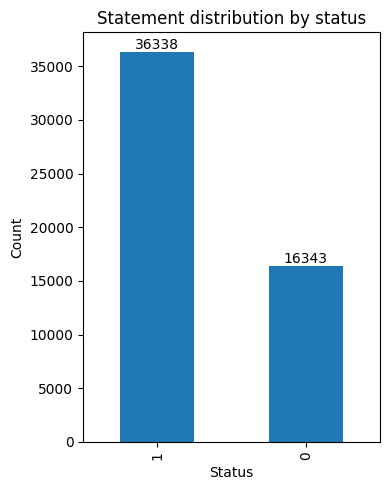

In [13]:
# As shown by below plot, there are 36338 'abnormal' while just 16343 'normal', which means there are class-imbalance issues
# Therefore, we would need to balance the class distribution in the training, we would try to do this by adjust class weights during training
plt.figure(figsize=(4, 5))
status_counts = df1['status'].value_counts()
ax = status_counts.plot(kind='bar')
for i, v in enumerate(status_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.title('Statement distribution by status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 1.1 SVM

In [14]:
random.seed(1234)

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],           # Regularization strength
    'kernel': ['linear', 'rbf'],    # Kernel types
    'class_weight': ['balanced', None],    # Handle class imbalance
    'gamma': ['scale', 'auto'],            # Kernel coefficient
}

# Initialize variables to track the best model and parameters
best_f1 = 0
best_model = None
best_params = None

# Start timer
start_time = time.time()

# Iterate through all combinations of parameters
for C, kernel, class_weight, gamma in product(param_grid['C'], param_grid['kernel'], param_grid['class_weight'], param_grid['gamma']):
    try:
        # Create the SVM model with current parameters
        model = SVC(C=C, kernel=kernel, class_weight=class_weight, gamma=gamma, random_state=42)

        # Train the model
        model.fit(X_train_1, y_train_1)

        # Validate the model on validation set
        y_val_pred = model.predict(X_val_1)
        f1 = f1_score(y_val_1, y_val_pred, average='weighted')
        print(f"Validation F1-Score for C={C}, kernel={kernel}, class_weight={class_weight}, gamma={gamma}: {f1:.4f}")

        # Update the best model if current one is better
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_params = {'C': C, 'kernel': kernel, 'class_weight': class_weight, 'gamma': gamma}
    except Exception as e:
        print(f"Skipping combination C={C}, kernel={kernel}, class_weight={class_weight}, gamma={gamma} due to error: {e}")

# End timer
end_time = time.time()
total_time = end_time - start_time
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")

# Print the best parameters and F1 score on validation set
print("\nBest Hyperparameters:", best_params)
print("Best Validation F1-Score:", best_f1)

Validation F1-Score for C=0.1, kernel=linear, class_weight=balanced, gamma=scale: 0.9081
Validation F1-Score for C=0.1, kernel=linear, class_weight=balanced, gamma=auto: 0.9081
Validation F1-Score for C=0.1, kernel=linear, class_weight=None, gamma=scale: 0.9260
Validation F1-Score for C=0.1, kernel=linear, class_weight=None, gamma=auto: 0.9260
Validation F1-Score for C=0.1, kernel=rbf, class_weight=balanced, gamma=scale: 0.8810
Validation F1-Score for C=0.1, kernel=rbf, class_weight=balanced, gamma=auto: 0.1498
Validation F1-Score for C=0.1, kernel=rbf, class_weight=None, gamma=scale: 0.9145
Validation F1-Score for C=0.1, kernel=rbf, class_weight=None, gamma=auto: 0.5586
Validation F1-Score for C=1, kernel=linear, class_weight=balanced, gamma=scale: 0.9293
Validation F1-Score for C=1, kernel=linear, class_weight=balanced, gamma=auto: 0.9293
Validation F1-Score for C=1, kernel=linear, class_weight=None, gamma=scale: 0.9353
Validation F1-Score for C=1, kernel=linear, class_weight=None, g

In [15]:
SVM = joblib.load("Models/svm_model_binary.pkl")

In [16]:
# Evaluate the Model on test set, with best parameters found
y_test_pred = SVM.predict(X_test_1)
print("\nTest Performance:")
print(classification_report(y_test_1, y_test_pred))
f1_score(y_test_1, y_test_pred, average='weighted')


Test Performance:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3308
           1       0.96      0.96      0.96      7229

    accuracy                           0.94     10537
   macro avg       0.93      0.93      0.93     10537
weighted avg       0.94      0.94      0.94     10537



0.9416557084656579

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    roc_curve,
    auc
)
from sklearn.utils import resample


def bootstrap_f1_ci(y_true, y_pred, n_iterations=1000, average='weighted'):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    f1_scores = []

    for _ in range(n_iterations):
        indices = resample(np.arange(len(y_true)))
        if len(np.unique(y_true[indices])) < 2:
            continue
        f1 = f1_score(y_true[indices], y_pred[indices], average=average)
        f1_scores.append(f1)

    f1_mean = np.mean(f1_scores)
    ci_lower = np.percentile(f1_scores, 2.5)
    ci_upper = np.percentile(f1_scores, 97.5)
    return f1_mean, ci_lower, ci_upper


def bootstrap_auc_ci(y_true, y_scores, n_iterations=1000):
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    auc_scores = []

    for _ in range(n_iterations):
        indices = resample(np.arange(len(y_true)))
        if len(np.unique(y_true[indices])) < 2:
            continue
        fpr, tpr, _ = roc_curve(y_true[indices], y_scores[indices])
        auc_score = auc(fpr, tpr)
        auc_scores.append(auc_score)

    ci_lower = np.percentile(auc_scores, 2.5)
    ci_upper = np.percentile(auc_scores, 97.5)
    return np.mean(auc_scores), ci_lower, ci_upper


def plot_confusion_matrix(y_true, y_pred, labels=['No Issue', 'Issue']):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


def plot_roc_curve(y_true, y_scores, label_prefix="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{label_prefix} AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {label_prefix}')
    plt.legend(loc='lower right')
    plt.show()
    return roc_auc


def evaluate_model(model, X_test, y_test, model_name="Model", use_proba=False):
    print(f"\n--- Evaluation Report: {model_name} ---\n")

    y_pred = model.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    f1_mean, f1_ci_low, f1_ci_high = bootstrap_f1_ci(y_test, y_pred)
    print(f"Weighted F1 Score: {f1_mean:.4f}")
    print(f"95% CI for F1 Score: [{f1_ci_low:.4f}, {f1_ci_high:.4f}]")

    plot_confusion_matrix(y_test, y_pred)

    # ROC + AUC
    if use_proba:
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)

    auc_score, auc_ci_low, auc_ci_high = bootstrap_auc_ci(y_test, y_scores)
    print(f"AUC Score: {auc_score:.4f}")
    print(f"95% CI for AUC: [{auc_ci_low:.4f}, {auc_ci_high:.4f}]")

    plot_roc_curve(y_test, y_scores, label_prefix=model_name)


# --- Usage Example ---
# For SVM with decision_function:
#evaluate_model(SVM, X_test_1, y_test_1, model_name="SVM", use_proba=False)

# For models like RandomForest or LogisticRegression with predict_proba:
# evaluate_model(rf_model, X_test, y_test, model_name="Random Forest", use_proba=True)



--- Evaluation Report: SVM ---

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3308
           1       0.96      0.96      0.96      7229

    accuracy                           0.94     10537
   macro avg       0.93      0.93      0.93     10537
weighted avg       0.94      0.94      0.94     10537

Weighted F1 Score: 0.9416
95% CI for F1 Score: [0.9370, 0.9462]


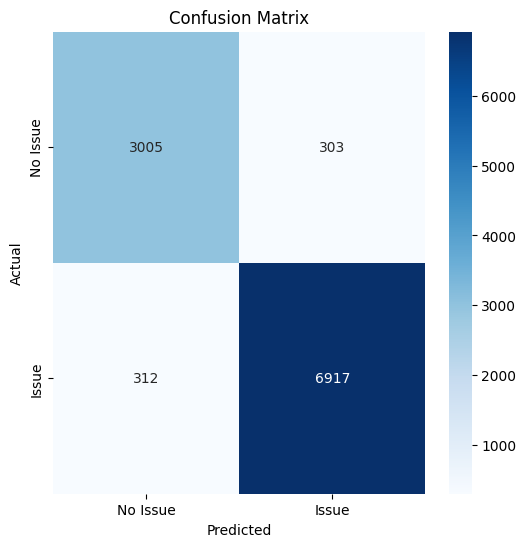

AUC Score: 0.9815
95% CI for AUC: [0.9794, 0.9838]


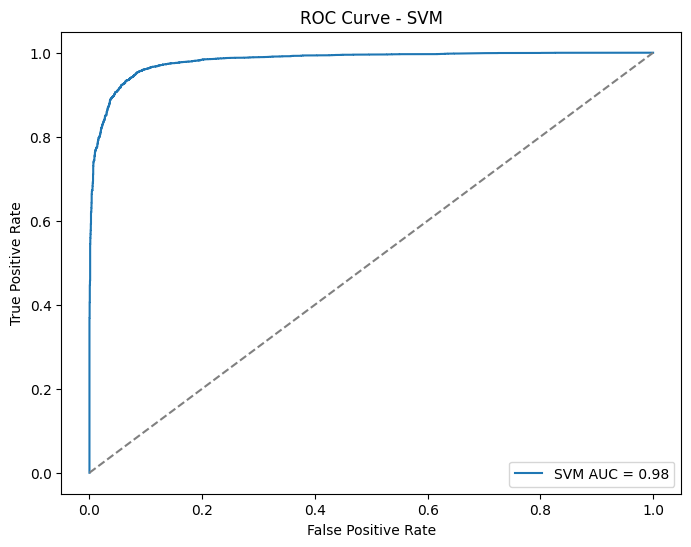

In [18]:
evaluate_model(SVM, X_test_1, y_test_1, model_name="SVM", use_proba=False)

## 1.2 Logistic Regression

In [19]:
# Define parameter grid

random.seed(1234)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],       # Regularization strength
    'solver': ['liblinear', 'lbfgs'],   # Optimization algorithms
    'penalty': ['l2'],                  # Regularization type
    'class_weight': ['balanced',None]  # Handle class imbalance - balanced is a choice to adjust class weights according to class frequency
}

# Grid search
best_f1 = 0
best_model = None
best_params = None

# Start timer
start_time = time.time()

# Iterate through all combinations of parameters, find the best params that works the best on validation set - primary metric: F1
for C, solver, penalty, class_weight in product(param_grid['C'], param_grid['solver'], param_grid['penalty'], param_grid['class_weight']):
    try:
        # Create the model with current parameters
        model = LogisticRegression(C=C, solver=solver, penalty=penalty, class_weight=class_weight, random_state=42, max_iter=1000)

        # Train the model
        model.fit(X_train_1, y_train_1)

        # Validate the model on validation set
        y_val_pred = model.predict(X_val_1)
        f1 = f1_score(y_val_1, y_val_pred,average='weighted')
        print(f"Validation F1-Score for C={C}, solver={solver}, penalty={penalty}, class_weight={class_weight}: {f1:.4f}")

        # Update the best model if current one is better
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_params = {'C': C, 'solver': solver, 'penalty': penalty, 'class_weight': class_weight}
    except Exception as e:
        print(f"Skipping combination C={C}, solver={solver}, penalty={penalty}, class_weight={class_weight} due to error: {e}")

# End timer
end_time = time.time()
total_time = end_time - start_time
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")

# Print the best parameters and F1 score on validation set
print("\nBest Hyperparameters:", best_params)
print("Best Validation F1-Score:", best_f1)

Validation F1-Score for C=0.01, solver=liblinear, penalty=l2, class_weight=balanced: 0.8459
Validation F1-Score for C=0.01, solver=liblinear, penalty=l2, class_weight=None: 0.5863
Validation F1-Score for C=0.01, solver=lbfgs, penalty=l2, class_weight=balanced: 0.8429
Validation F1-Score for C=0.01, solver=lbfgs, penalty=l2, class_weight=None: 0.5857
Validation F1-Score for C=0.1, solver=liblinear, penalty=l2, class_weight=balanced: 0.8845
Validation F1-Score for C=0.1, solver=liblinear, penalty=l2, class_weight=None: 0.9087
Validation F1-Score for C=0.1, solver=lbfgs, penalty=l2, class_weight=balanced: 0.8838
Validation F1-Score for C=0.1, solver=lbfgs, penalty=l2, class_weight=None: 0.9087
Validation F1-Score for C=1, solver=liblinear, penalty=l2, class_weight=balanced: 0.9196
Validation F1-Score for C=1, solver=liblinear, penalty=l2, class_weight=None: 0.9331
Validation F1-Score for C=1, solver=lbfgs, penalty=l2, class_weight=balanced: 0.9189
Validation F1-Score for C=1, solver=lbfgs

In [20]:
LR = LogisticRegression(C=10, solver='lbfgs', penalty='l2', class_weight=None, random_state=42, max_iter=1000)
LR.fit(X_train_1, y_train_1)

LogisticRegression(C=10, max_iter=1000, random_state=42)


--- Evaluation Report: LR ---

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3308
           1       0.95      0.95      0.95      7229

    accuracy                           0.94     10537
   macro avg       0.93      0.93      0.93     10537
weighted avg       0.94      0.94      0.94     10537

Weighted F1 Score: 0.9364
95% CI for F1 Score: [0.9317, 0.9412]


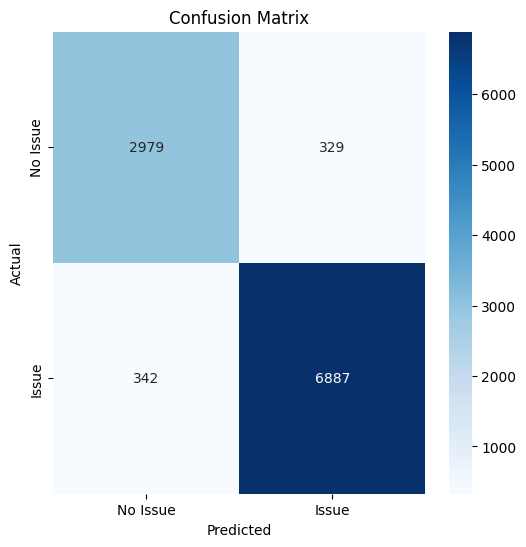

AUC Score: 0.9784
95% CI for AUC: [0.9758, 0.9807]


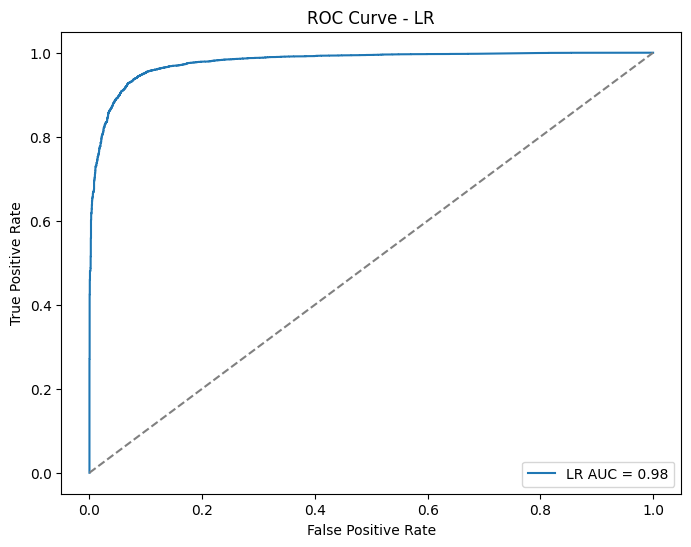

In [21]:
evaluate_model(LR, X_test_1, y_test_1, model_name="LR", use_proba=True)

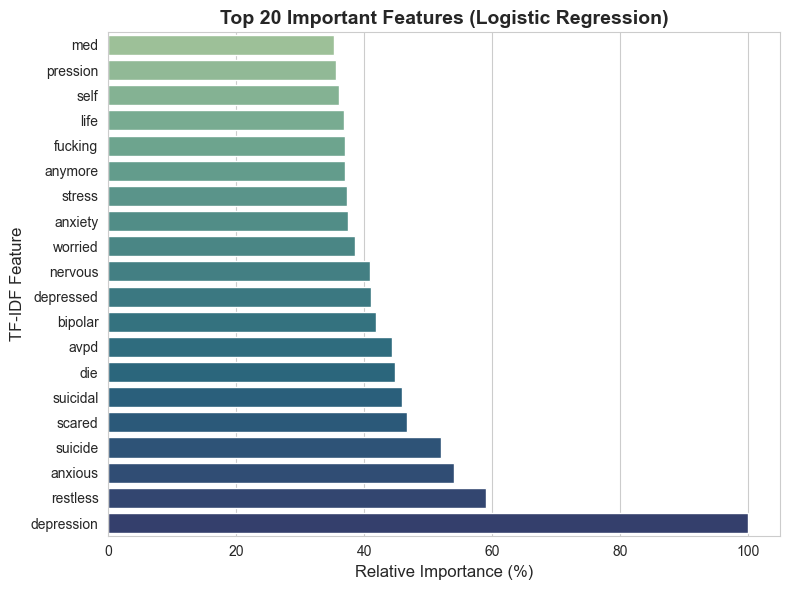

         Feature  Coefficient  Scaled Importance
2287  depression    23.390375         100.000000
7390    restless    13.797117          58.986304
412      anxious    12.645218          54.061632
8587     suicide    12.155925          51.969776
7640      scared    10.909049          46.639050
8584    suicidal    10.729209          45.870187
2388         die    10.477631          44.794627
661         avpd    10.393295          44.434068
896      bipolar     9.792005          41.863397
2282   depressed     9.620275          41.129204
5819     nervous     9.559678          40.870138
9869     worried     9.010162          38.520812
408      anxiety     8.774245          37.512203
8467      stress     8.737335          37.354404
417      anymore     8.676387          37.093833
3615     fucking     8.646679          36.966827
5081        life     8.622465          36.863305
7748        self     8.426424          36.025179
6712    pression     8.345217          35.677997
5422         med    

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Extract feature names
feature_names = tfidf.get_feature_names_out()

# Extract coefficients from the trained Logistic Regression model
coefficients = LR.coef_[0]

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Use absolute value for importance
importance_df['Importance (Abs)'] = importance_df['Coefficient'].abs()

# Normalize importance (rescale to 0–100)
importance_df['Scaled Importance'] = (
    importance_df['Importance (Abs)'] / importance_df['Importance (Abs)'].max()
) * 100

# Sort and take top 20
top_20_features = importance_df.sort_values(by='Importance (Abs)', ascending=False).head(20)

# Plot (horizontal bar chart)
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.barplot(
    x='Scaled Importance',
    y='Feature',
    data=top_20_features[::-1],  # Reverse for descending top-down
    palette="crest"
)

plt.title("Top 20 Important Features (Logistic Regression)", fontsize=14, fontweight='bold')
plt.xlabel("Relative Importance (%)", fontsize=12)
plt.ylabel("TF-IDF Feature", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Save high-res for paper
plt.savefig("top_features_lr.png", dpi=300)
plt.show()

# Optionally print the top 20
print(top_20_features[['Feature', 'Coefficient', 'Scaled Importance']])


## 1.3 Random Forest

In [23]:
#Define the Hyperparameter Tuning grid
random.seed(1234)

param_grid = {
    'n_estimators': [50, 100, 200],        # Number of trees
    'max_depth': [10, 20, None],           # Maximum depth of trees
    'min_samples_split': [2, 5, 10],       # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],         # Minimum samples at a leaf node
    'class_weight': [None, 'balanced']     # Handle class imbalance - balanced is a choice to adjust class weights according to class frequency
}

# Grid search
best_f1 = 0
best_model = None
best_params = None


# Start timer
start_time = time.time()

# Iterate through all combinations of parameters
for n_estimators, max_depth, min_samples_split, min_samples_leaf, class_weight in product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['min_samples_leaf'],
    param_grid['class_weight']
):
    try:
        # Create the Random Forest model with current parameters
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            class_weight=class_weight,
            random_state=42,
            n_jobs=-1
        )

        # Train the model
        model.fit(X_train_1, y_train_1)

        # Validate the model on validation set
        y_val_pred = model.predict(X_val_1)
        f1 = f1_score(y_val_1, y_val_pred,average='weighted')
        print(f"Validation F1-Score for n_estimators={n_estimators}, max_depth={max_depth}, "
              f"min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, "
              f"class_weight={class_weight}: {f1:.4f}")

        # Update the best model if current one is better
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_params = {
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'class_weight': class_weight
            }
    except Exception as e:
        print(f"Skipping combination n_estimators={n_estimators}, max_depth={max_depth}, "
              f"min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, "
              f"class_weight={class_weight} due to error: {e}")

# End timer
end_time = time.time()
total_time = end_time - start_time


# Print the best parameters and F1 score on validation set
print("\nBest Hyperparameters:", best_params)
print("Best Validation F1-Score:", best_f1)
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")

Validation F1-Score for n_estimators=50, max_depth=10, min_samples_split=2, min_samples_leaf=1, class_weight=None: 0.5648
Validation F1-Score for n_estimators=50, max_depth=10, min_samples_split=2, min_samples_leaf=1, class_weight=balanced: 0.8245
Validation F1-Score for n_estimators=50, max_depth=10, min_samples_split=2, min_samples_leaf=2, class_weight=None: 0.5644
Validation F1-Score for n_estimators=50, max_depth=10, min_samples_split=2, min_samples_leaf=2, class_weight=balanced: 0.8216
Validation F1-Score for n_estimators=50, max_depth=10, min_samples_split=2, min_samples_leaf=4, class_weight=None: 0.5644
Validation F1-Score for n_estimators=50, max_depth=10, min_samples_split=2, min_samples_leaf=4, class_weight=balanced: 0.8200
Validation F1-Score for n_estimators=50, max_depth=10, min_samples_split=5, min_samples_leaf=1, class_weight=None: 0.5639
Validation F1-Score for n_estimators=50, max_depth=10, min_samples_split=5, min_samples_leaf=1, class_weight=balanced: 0.8245
Validati

In [24]:
RandomForest = RandomForestClassifier(
    n_estimators=50,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Train the model
RandomForest.fit(X_train_1, y_train_1)


RandomForestClassifier(class_weight='balanced', n_estimators=50, n_jobs=-1,
                       random_state=42)


--- Evaluation Report: Random Forest ---

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      3308
           1       0.94      0.96      0.95      7229

    accuracy                           0.94     10537
   macro avg       0.93      0.92      0.92     10537
weighted avg       0.93      0.94      0.93     10537

Weighted F1 Score: 0.9347
95% CI for F1 Score: [0.9301, 0.9394]


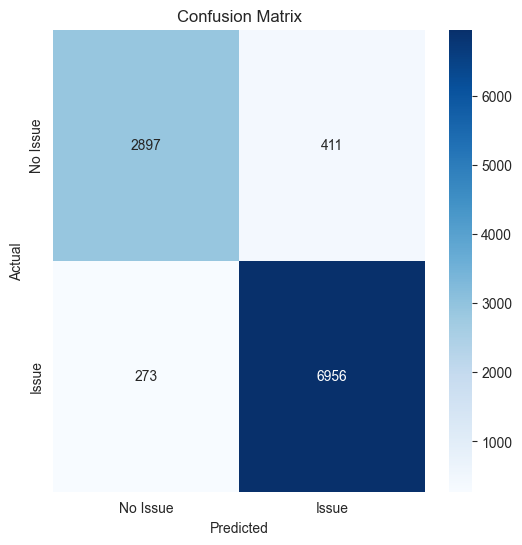

AUC Score: 0.9764
95% CI for AUC: [0.9737, 0.9791]


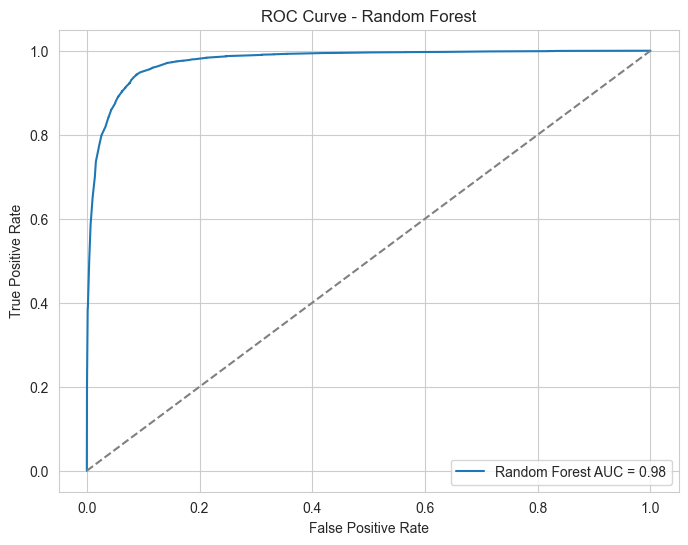

In [25]:
evaluate_model(RandomForest, X_test_1, y_test_1, model_name="Random Forest", use_proba=True)

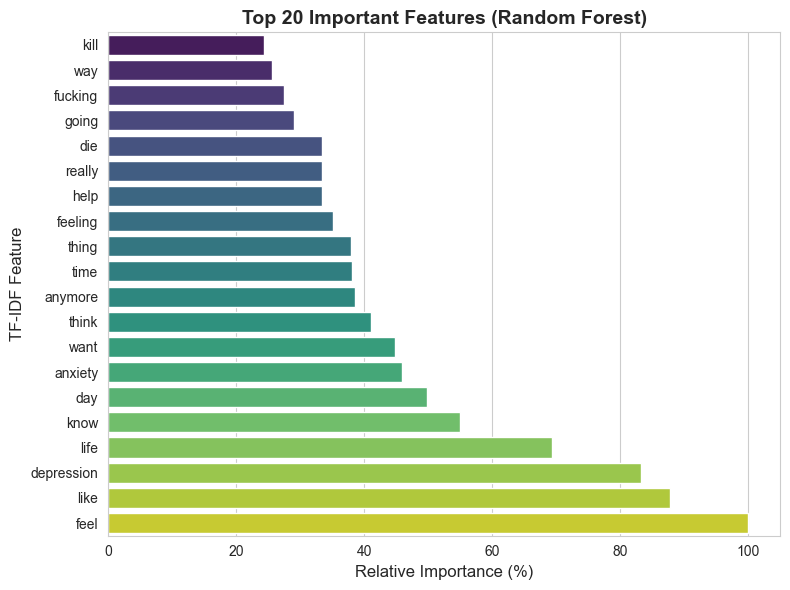

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure the best_model is available after parameter tuning
if RandomForest is not None:
    # Get the feature names from TfidfVectorizer
    feature_names = tfidf.get_feature_names_out()

    # Get the feature importances from the trained Random Forest model
    feature_importance = RandomForest.feature_importances_
    feature_importance = (feature_importance / feature_importance.max()) * 100

    # Map feature importance to feature names
    important_features = sorted(
        zip(feature_importance, feature_names),
        key=lambda x: x[0],
        reverse=True
    )

    # Select top N features
    top_n = 20
    top_features = important_features[:top_n]
    importances, names = zip(*top_features)

    # Reverse for horizontal bar plot
    importances = importances[::-1]
    names = names[::-1]

    # Plot
    plt.figure(figsize=(8, 6))
    sns.set_style("whitegrid")
    sns.barplot(x=importances, y=names, palette="viridis")

    plt.title("Top 20 Important Features (Random Forest)", fontsize=14, fontweight='bold')
    plt.xlabel("Relative Importance (%)", fontsize=12)
    plt.ylabel("TF-IDF Feature", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Save high-res for paper
    plt.savefig("top_features_rf.png", dpi=300)
    plt.show()
else:
    print("No model was trained successfully. Unable to display feature importance.")


## 1.4 LGBM

In [27]:
random.seed(1234)

param_grid = {
    'n_estimators': [50, 100],            # Reduced to two options for number of boosting iterations
    'learning_rate': [0.01, 0.1],         # Reduced to two commonly used learning rates
    'max_depth': [-1, 10],                # Focus on unlimited depth (-1) and a typical max depth (10)
    'num_leaves': [31, 50],               # Removed larger values for simplicity
    'min_child_samples': [10, 20],        # Focused on fewer options for minimum child samples
    'class_weight': [None, 'balanced']    # Retained both options for class imbalance handling
}

# Grid search
best_f1 = 0
best_model = None
best_params = None

# Start timer
start_time = time.time()

# Iterate through all combinations of parameters
for n_estimators, learning_rate, max_depth, num_leaves, min_child_samples, class_weight in product(
    param_grid['n_estimators'],
    param_grid['learning_rate'],
    param_grid['max_depth'],
    param_grid['num_leaves'],
    param_grid['min_child_samples'],
    param_grid['class_weight']
):
    try:
        # Create the LightGBM model with current parameters
        model = LGBMClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            num_leaves=num_leaves,
            min_child_samples=min_child_samples,
            class_weight=class_weight,
            random_state=42,
            n_jobs=-1,
            importance_type = "gain"
        )

        # Train the model
        model.fit(X_train_1, y_train_1)

        # Validate the model
        y_val_pred = model.predict(X_val_1)
        f1 = f1_score(y_val_1, y_val_pred,average = 'weighted')
        print(f"Validation F1-Score for n_estimators={n_estimators}, learning_rate={learning_rate}, "
              f"max_depth={max_depth}, num_leaves={num_leaves}, "
              f"min_child_samples={min_child_samples}, class_weight={class_weight}: {f1:.4f}")

        # Update the best model if current one is better
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_params = {
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'num_leaves': num_leaves,
                'min_child_samples': min_child_samples,
                'class_weight': class_weight
            }
    except Exception as e:
        print(f"Skipping combination n_estimators={n_estimators}, learning_rate={learning_rate}, "
              f"max_depth={max_depth}, num_leaves={num_leaves}, "
              f"min_child_samples={min_child_samples}, class_weight={class_weight} due to error: {e}")

# End timer
end_time = time.time()
total_time = end_time - start_time

# Print the best parameters and F1 score
print("\nBest Hyperparameters:", best_params)
print("Best Validation F1-Score:", best_f1)
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")

[LightGBM] [Info] Number of positive: 21878, number of negative: 9730
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.110909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 245313
[LightGBM] [Info] Number of data points in the train set: 31608, number of used features: 6982
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.692167 -> initscore=0.810268
[LightGBM] [Info] Start training from score 0.810268
Validation F1-Score for n_estimators=50, learning_rate=0.01, max_depth=-1, num_leaves=31, min_child_samples=10, class_weight=None: 0.8637
[LightGBM] [Info] Number of positive: 21878, number of negative: 9730
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.311469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 245313
[LightGBM] [Info] Number of data points in the train set: 31608, number of used features: 6982
[Lig

In [28]:
LGBM = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=50,
    min_child_samples=10,
    class_weight=None,
    random_state=42,
    n_jobs=-1,
    importance_type = "gain"
)

# Train the model
LGBM.fit(X_train_1, y_train_1)

[LightGBM] [Info] Number of positive: 21878, number of negative: 9730
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.092395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 245313
[LightGBM] [Info] Number of data points in the train set: 31608, number of used features: 6982
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.692167 -> initscore=0.810268
[LightGBM] [Info] Start training from score 0.810268


LGBMClassifier(importance_type='gain', min_child_samples=10, n_jobs=-1,
               num_leaves=50, random_state=42)


--- Evaluation Report: LGBM ---

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3308
           1       0.95      0.95      0.95      7229

    accuracy                           0.94     10537
   macro avg       0.93      0.93      0.93     10537
weighted avg       0.94      0.94      0.94     10537

Weighted F1 Score: 0.9363
95% CI for F1 Score: [0.9316, 0.9407]


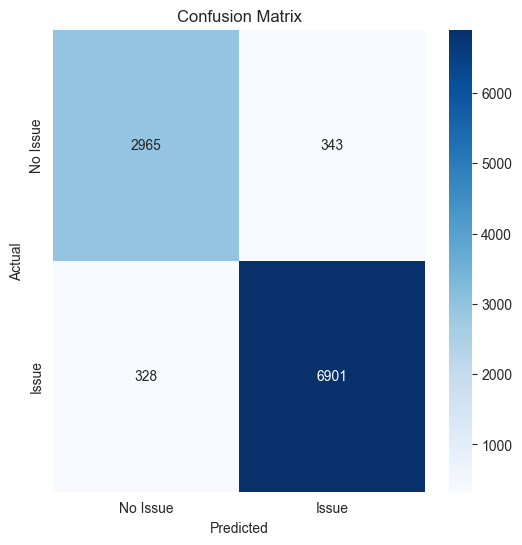

AUC Score: 0.9802
95% CI for AUC: [0.9780, 0.9824]


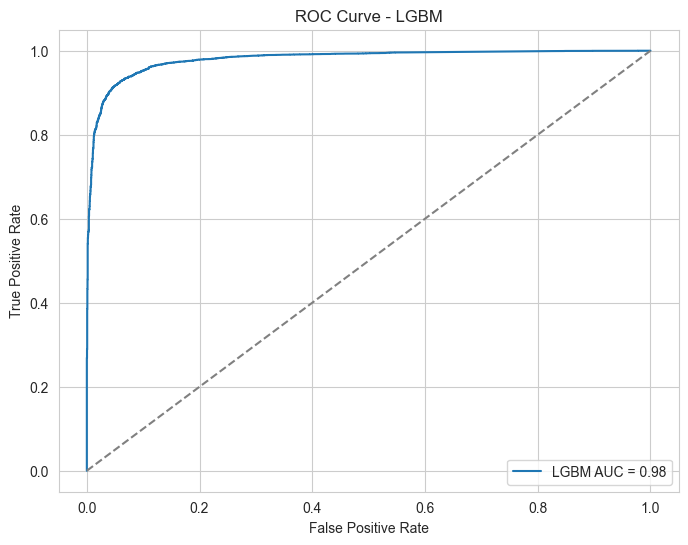

In [29]:
evaluate_model(LGBM, X_test_1, y_test_1, model_name="LGBM", use_proba=True)

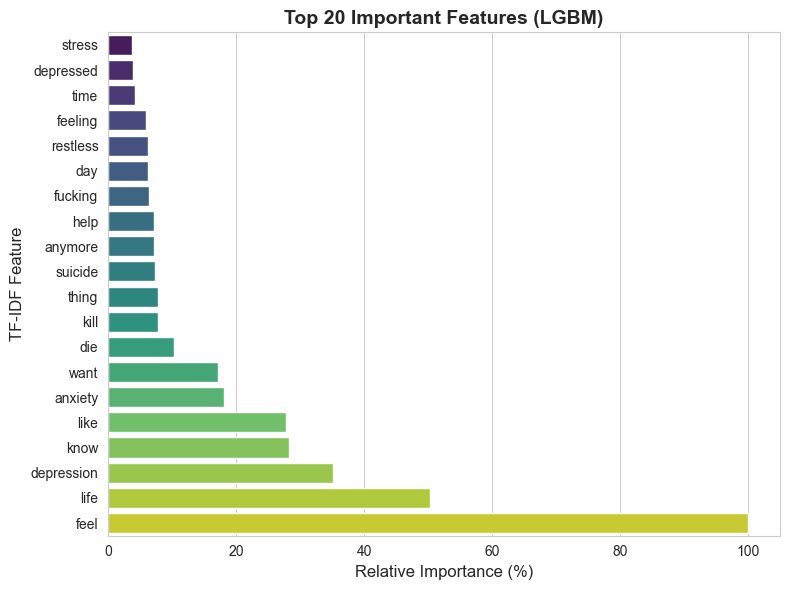

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure the best_model is available after parameter tuning
if LGBM is not None:
    # Get the feature names from TfidfVectorizer
    feature_names = tfidf.get_feature_names_out()

    # Get the feature importances from the trained Random Forest model
    feature_importance = LGBM.feature_importances_
    feature_importance = (feature_importance / feature_importance.max()) * 100

    # Map feature importance to feature names
    important_features = sorted(
        zip(feature_importance, feature_names),
        key=lambda x: x[0],
        reverse=True
    )

    # Select top N features
    top_n = 20
    top_features = important_features[:top_n]
    importances, names = zip(*top_features)

    # Reverse for horizontal bar plot
    importances = importances[::-1]
    names = names[::-1]

    # Plot
    plt.figure(figsize=(8, 6))
    sns.set_style("whitegrid")
    sns.barplot(x=importances, y=names, palette="viridis")

    plt.title("Top 20 Important Features (LGBM)", fontsize=14, fontweight='bold')
    plt.xlabel("Relative Importance (%)", fontsize=12)
    plt.ylabel("TF-IDF Feature", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Save high-res for paper
    plt.savefig("top_features_lgbm.png", dpi=300)
    plt.show()
else:
    print("No model was trained successfully. Unable to display feature importance.")


### Compare performance with Stats Test

In [31]:
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import accuracy_score
import numpy as np

def run_mcnemar_test(y_true, y_pred_1, y_pred_2, model_1_name="Model 1", model_2_name="Model 2"):
    assert len(y_true) == len(y_pred_1) == len(y_pred_2), "Length mismatch."

    # Create contingency table
    both_correct = np.sum((y_pred_1 == y_true) & (y_pred_2 == y_true))
    model1_correct = np.sum((y_pred_1 == y_true) & (y_pred_2 != y_true))
    model2_correct = np.sum((y_pred_1 != y_true) & (y_pred_2 == y_true))
    both_wrong = np.sum((y_pred_1 != y_true) & (y_pred_2 != y_true))

    table = [[both_correct, model2_correct],
             [model1_correct, both_wrong]]

    result = mcnemar(table, exact=False, correction=True)
    print(f"\n--- McNemar’s Test: {model_1_name} vs {model_2_name} ---")
    print(f"Statistic = {result.statistic:.4f}, p-value = {result.pvalue:.4f}")
    if result.pvalue < 0.05:
        print("=> Significant difference.")
    else:
        print("=> No significant difference.")
SVM_preds = SVM.predict(X_test_1)
LGBM_preds = LGBM.predict(X_test_1)
run_mcnemar_test(y_test_1, SVM_preds, LGBM_preds, "SVM", "LGBM")





--- McNemar’s Test: SVM vs LGBM ---
Statistic = 6.7522, p-value = 0.0094
=> Significant difference.


In [32]:
RandomForest_preds = RandomForest.predict(X_test_1)
LR_preds = LR.predict(X_test_1)

## Cross-Domain Generalization Test On Complete New Dataset

In [33]:
new_test = pd.read_csv('Sentiment_Mental_health_dataset.csv')

In [34]:
new_test.head()

statement                status
0  Anyone else have symptoms much improved after ...               Bipolar
1  I basicaly do not exist, sure feels that way. ...              Suicidal
2  Finding a sense of self It's like one minute I...  Personality_disorder
3  Putting into words what were just tangles in m...               Anxiety
4  Anxiety makes me worry about my public image s...               Anxiety

In [35]:
new_test.dropna(inplace = True)

In [36]:
new_test.shape

(26350, 2)

In [37]:
new_test['status'].value_counts()

status
Suicidal                5600
Anxiety                 4704
Normal                  4575
Depression              4111
Personality_disorder    2817
Bipolar                 2720
Stress                  1823
Name: count, dtype: int64

In [38]:
new_test.describe().T

count unique       top  freq
statement  26350  26329         .     4
status     26350      7  Suicidal  5600

In [39]:
new_test['status'] = new_test['status'].apply(lambda x : 1 if x != 'Normal' else 0)

In [40]:
new_test['status'].value_counts()

status
1    21775
0     4575
Name: count, dtype: int64

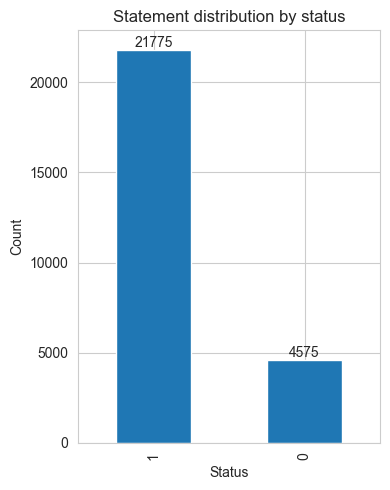

In [41]:
# As shown by below plot, there are 21775 'abnormal' while just 4575 'normal', which means there are class-imbalance issues
# Therefore, we would need to balance the class distribution in the training, we would try to do this by adjust class weights during training
plt.figure(figsize=(4, 5))
status_counts = new_test['status'].value_counts()
ax = status_counts.plot(kind='bar')
for i, v in enumerate(status_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.title('Statement distribution by status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Pre-processing for classical ML Models

In [42]:
# Step 1: Clean the Text
# Purpose: Removes noise (e.g., special characters, extra spaces) that doesn't contribute to understanding the text's meaning.
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

new_test['statement'] = new_test['statement'].apply(clean_text)

In [43]:
stop_words = set(stopwords.words('english'))
new_test['statement'] = new_test['statement'].apply(lambda x : ' '.join([word for word in x.split() if word not in stop_words]))

In [44]:
lemmatizer = WordNetLemmatizer()
new_test['statement'] = new_test['statement'].apply(lambda x : ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [45]:
x_new = new_test['statement'].tolist()
y_new = new_test['status'].tolist()

In [46]:
# new_test.shape, x_new.shape, y_new.shape

In [47]:
_, x_new, _, y_new = train_test_split(
    X1, y1, test_size=0.2, random_state=42
)

In [48]:
import joblib
vectorizer = joblib.load("Models/tfidf_vectorizer_2_binary.pkl")

x_test_new = vectorizer.transform(x_new)

In [49]:
SVM = joblib.load("Models/svm_model_binary.pkl")

In [50]:
y_pred_new = SVM.predict(x_test_new)
print('\nTest Performance on New Dataset:')
print(classification_report(y_new, y_pred_new))
f1_score(y_new, y_pred_new, average = 'weighted')


Test Performance on New Dataset:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3308
           1       0.96      0.96      0.96      7229

    accuracy                           0.94     10537
   macro avg       0.93      0.93      0.93     10537
weighted avg       0.94      0.94      0.94     10537



0.9416557084656579

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    roc_curve,
    auc
)
from sklearn.utils import resample


def bootstrap_f1_ci(y_true, y_pred, n_iterations=1000, average='weighted'):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    f1_scores = []

    for _ in range(n_iterations):
        indices = resample(np.arange(len(y_true)))
        if len(np.unique(y_true[indices])) < 2:
            continue
        f1 = f1_score(y_true[indices], y_pred[indices], average=average)
        f1_scores.append(f1)

    f1_mean = np.mean(f1_scores)
    ci_lower = np.percentile(f1_scores, 2.5)
    ci_upper = np.percentile(f1_scores, 97.5)
    return f1_mean, ci_lower, ci_upper


def bootstrap_auc_ci(y_true, y_scores, n_iterations=1000):
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    auc_scores = []

    for _ in range(n_iterations):
        indices = resample(np.arange(len(y_true)))
        if len(np.unique(y_true[indices])) < 2:
            continue
        fpr, tpr, _ = roc_curve(y_true[indices], y_scores[indices])
        auc_score = auc(fpr, tpr)
        auc_scores.append(auc_score)

    ci_lower = np.percentile(auc_scores, 2.5)
    ci_upper = np.percentile(auc_scores, 97.5)
    return np.mean(auc_scores), ci_lower, ci_upper


def plot_confusion_matrix(y_true, y_pred, labels=['No Issue', 'Issue']):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


def plot_roc_curve(y_true, y_scores, label_prefix="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{label_prefix} AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {label_prefix}')
    plt.legend(loc='lower right')
    plt.show()
    return roc_auc


def evaluate_model(model, X_test, y_test, model_name="Model", use_proba=False):
    print(f"\n--- Evaluation Report: {model_name} ---\n")

    y_pred = model.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    f1_mean, f1_ci_low, f1_ci_high = bootstrap_f1_ci(y_test, y_pred)
    print(f"Weighted F1 Score: {f1_mean:.4f}")
    print(f"95% CI for F1 Score: [{f1_ci_low:.4f}, {f1_ci_high:.4f}]")

    plot_confusion_matrix(y_test, y_pred)

    # ROC + AUC
    if use_proba:
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)

    auc_score, auc_ci_low, auc_ci_high = bootstrap_auc_ci(y_test, y_scores)
    print(f"AUC Score: {auc_score:.4f}")
    print(f"95% CI for AUC: [{auc_ci_low:.4f}, {auc_ci_high:.4f}]")

    plot_roc_curve(y_test, y_scores, label_prefix=model_name)


# --- Usage Example ---
# For SVM with decision_function:
#evaluate_model(SVM, X_test_1, y_test_1, model_name="SVM", use_proba=False)

# For models like RandomForest or LogisticRegression with predict_proba:
# evaluate_model(rf_model, X_test, y_test, model_name="Random Forest", use_proba=True)


### SVM 


--- Evaluation Report: SVM ---

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3308
           1       0.96      0.96      0.96      7229

    accuracy                           0.94     10537
   macro avg       0.93      0.93      0.93     10537
weighted avg       0.94      0.94      0.94     10537

Weighted F1 Score: 0.9417
95% CI for F1 Score: [0.9369, 0.9462]


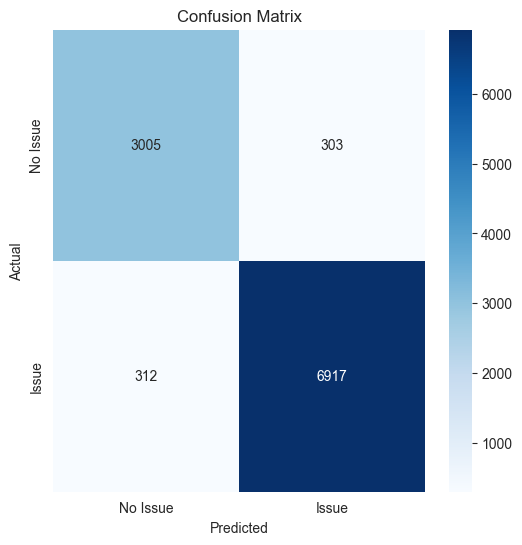

AUC Score: 0.9816
95% CI for AUC: [0.9794, 0.9837]


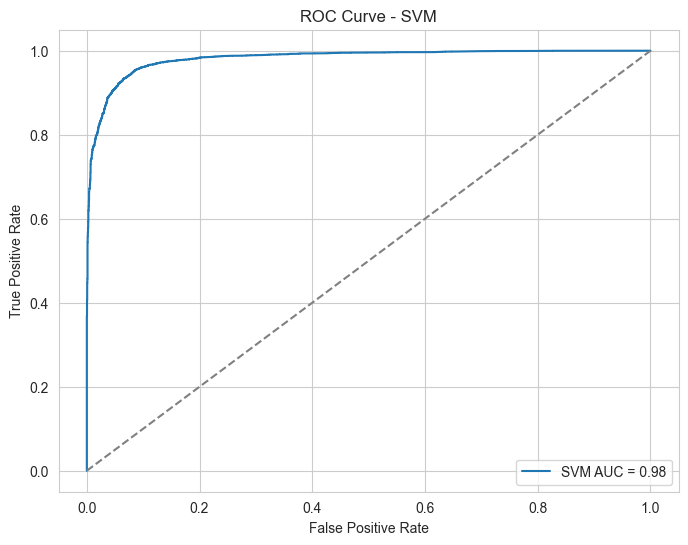

In [52]:
evaluate_model(SVM, x_test_new, y_new, model_name="SVM", use_proba=False)

### LR


--- Evaluation Report: LR ---

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3308
           1       0.95      0.95      0.95      7229

    accuracy                           0.94     10537
   macro avg       0.93      0.93      0.93     10537
weighted avg       0.94      0.94      0.94     10537

Weighted F1 Score: 0.9363
95% CI for F1 Score: [0.9316, 0.9407]


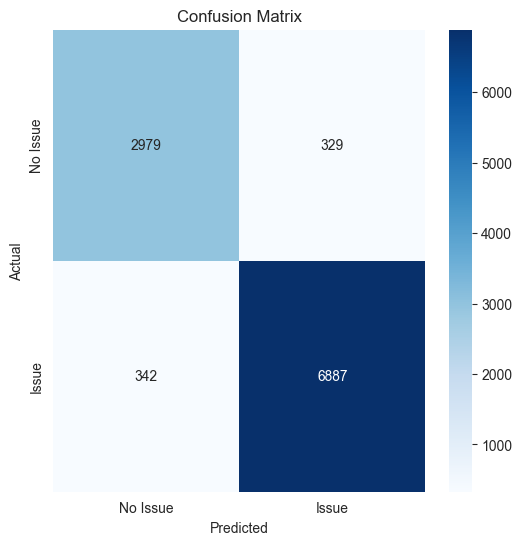

AUC Score: 0.9783
95% CI for AUC: [0.9758, 0.9807]


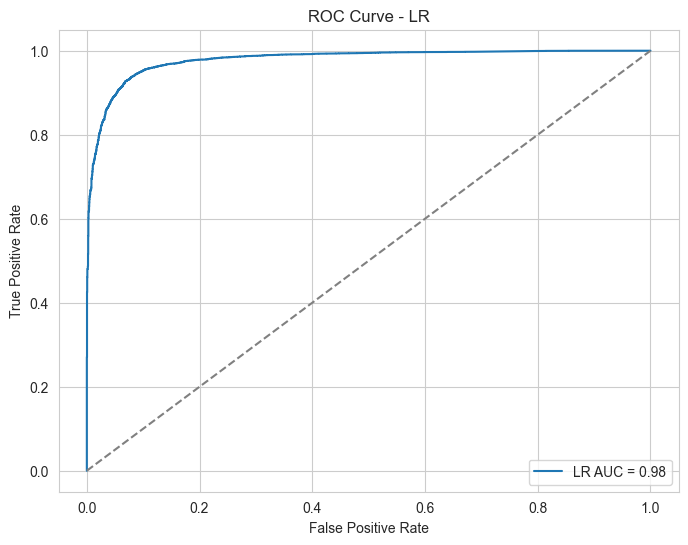

In [53]:
evaluate_model(LR, x_test_new, y_new, model_name="LR", use_proba=True)

### Random Forest


--- Evaluation Report: Random Forest ---

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      3308
           1       0.94      0.96      0.95      7229

    accuracy                           0.94     10537
   macro avg       0.93      0.92      0.92     10537
weighted avg       0.93      0.94      0.93     10537

Weighted F1 Score: 0.9349
95% CI for F1 Score: [0.9300, 0.9398]


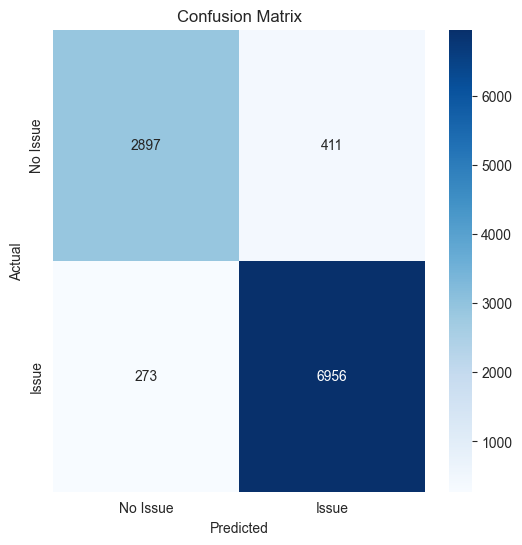

AUC Score: 0.9764
95% CI for AUC: [0.9736, 0.9790]


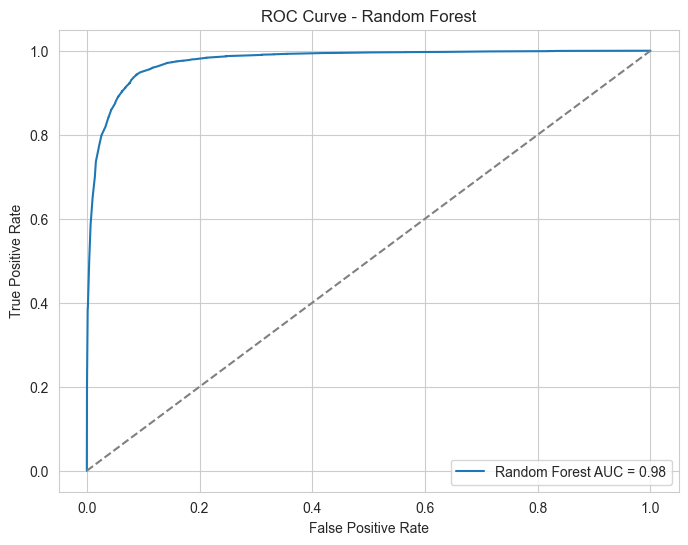

In [54]:
evaluate_model(RandomForest, x_test_new, y_new, model_name="Random Forest", use_proba=True)

### LGBM


--- Evaluation Report: LGBM ---

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3308
           1       0.95      0.95      0.95      7229

    accuracy                           0.94     10537
   macro avg       0.93      0.93      0.93     10537
weighted avg       0.94      0.94      0.94     10537

Weighted F1 Score: 0.9364
95% CI for F1 Score: [0.9318, 0.9411]


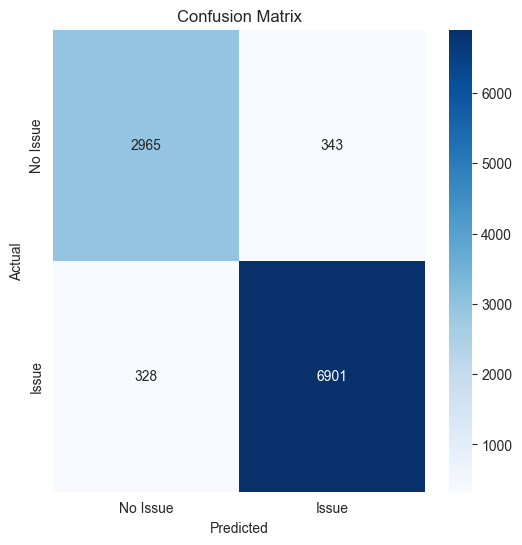

AUC Score: 0.9802
95% CI for AUC: [0.9778, 0.9824]


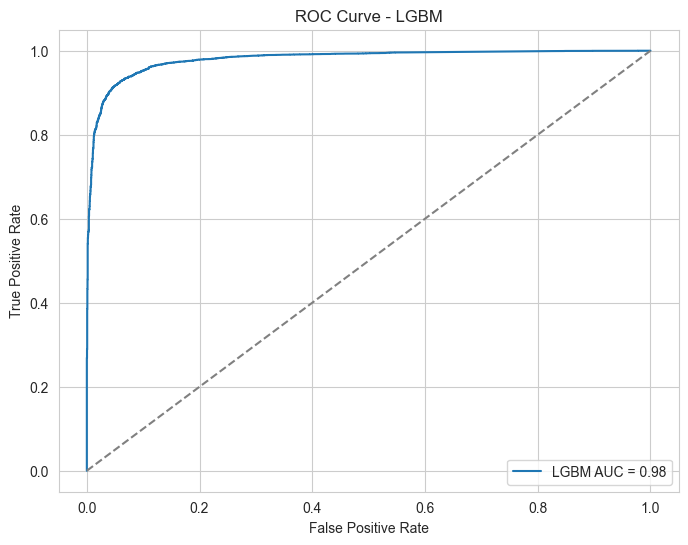

In [55]:
evaluate_model(LGBM, x_test_new, y_new, model_name="LGBM", use_proba=True)

## Cross-Domain Generalization Test On Merge New Dataset

In [56]:
new_test = pd.read_csv('Final_Merged_Dataset_Cleaned.csv')

In [57]:
new_test.head()

statement    status
0                     That’s it that’s the post lmao  Suicidal
1  Before exam I am so stressed out that I am not...    Stress
2  I’m afraid of having my pictures taken Ever si...   Anxiety
3  Let's say a totally optimally fit person were ...    Normal
4  And no, this is not teenage angst. This is not...  Suicidal

In [58]:
new_test.dropna(inplace = True)

In [59]:
new_test.shape

(41835, 2)

In [60]:
new_test['status'].value_counts()

status
Normal                  8573
Suicidal                8400
Depression              7111
Anxiety                 6485
Bipolar                 4367
Personality disorder    3623
Stress                  3276
Name: count, dtype: int64

In [61]:
new_test.describe().T

count unique                top  freq
statement  41835  41077  what do you mean?     7
status     41835      7             Normal  8573

In [62]:
new_test['status'] = new_test['status'].apply(lambda x : 1 if x != 'Normal' else 0)

In [63]:
new_test['status'].value_counts()

status
1    33262
0     8573
Name: count, dtype: int64

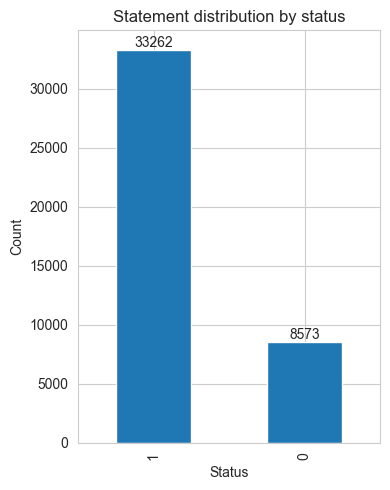

In [64]:
# As shown by below plot, there are 21775 'abnormal' while just 4575 'normal', which means there are class-imbalance issues
# Therefore, we would need to balance the class distribution in the training, we would try to do this by adjust class weights during training
plt.figure(figsize=(4, 5))
status_counts = new_test['status'].value_counts()
ax = status_counts.plot(kind='bar')
for i, v in enumerate(status_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.title('Statement distribution by status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Pre-processing for classical ML Models

In [65]:
# Step 1: Clean the Text
# Purpose: Removes noise (e.g., special characters, extra spaces) that doesn't contribute to understanding the text's meaning.
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

new_test['statement'] = new_test['statement'].apply(clean_text)

In [66]:
stop_words = set(stopwords.words('english'))
new_test['statement'] = new_test['statement'].apply(lambda x : ' '.join([word for word in x.split() if word not in stop_words]))

In [67]:
lemmatizer = WordNetLemmatizer()
new_test['statement'] = new_test['statement'].apply(lambda x : ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [68]:
x_new = new_test['statement'].tolist()
y_new = new_test['status'].tolist()

In [69]:
_, x_new, _, y_new = train_test_split(
    X1, y1, test_size=0.2, random_state=42
)

In [70]:
import joblib
vectorizer = joblib.load("Models/tfidf_vectorizer_2_binary.pkl")

x_test_new = vectorizer.transform(x_new)

In [71]:
SVM = joblib.load("Models/svm_model_binary.pkl")

In [72]:
y_pred_new = SVM.predict(x_test_new)
print('\nTest Performance on New Dataset:')
print(classification_report(y_new, y_pred_new))
f1_score(y_new, y_pred_new, average = 'weighted')


Test Performance on New Dataset:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3308
           1       0.96      0.96      0.96      7229

    accuracy                           0.94     10537
   macro avg       0.93      0.93      0.93     10537
weighted avg       0.94      0.94      0.94     10537



0.9416557084656579

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    roc_curve,
    auc
)
from sklearn.utils import resample


def bootstrap_f1_ci(y_true, y_pred, n_iterations=1000, average='weighted'):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    f1_scores = []

    for _ in range(n_iterations):
        indices = resample(np.arange(len(y_true)))
        if len(np.unique(y_true[indices])) < 2:
            continue
        f1 = f1_score(y_true[indices], y_pred[indices], average=average)
        f1_scores.append(f1)

    f1_mean = np.mean(f1_scores)
    ci_lower = np.percentile(f1_scores, 2.5)
    ci_upper = np.percentile(f1_scores, 97.5)
    return f1_mean, ci_lower, ci_upper


def bootstrap_auc_ci(y_true, y_scores, n_iterations=1000):
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    auc_scores = []

    for _ in range(n_iterations):
        indices = resample(np.arange(len(y_true)))
        if len(np.unique(y_true[indices])) < 2:
            continue
        fpr, tpr, _ = roc_curve(y_true[indices], y_scores[indices])
        auc_score = auc(fpr, tpr)
        auc_scores.append(auc_score)

    ci_lower = np.percentile(auc_scores, 2.5)
    ci_upper = np.percentile(auc_scores, 97.5)
    return np.mean(auc_scores), ci_lower, ci_upper


def plot_confusion_matrix(y_true, y_pred, labels=['No Issue', 'Issue']):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


def plot_roc_curve(y_true, y_scores, label_prefix="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{label_prefix} AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {label_prefix}')
    plt.legend(loc='lower right')
    plt.show()
    return roc_auc


def evaluate_model(model, X_test, y_test, model_name="Model", use_proba=False):
    print(f"\n--- Evaluation Report: {model_name} ---\n")

    y_pred = model.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    f1_mean, f1_ci_low, f1_ci_high = bootstrap_f1_ci(y_test, y_pred)
    print(f"Weighted F1 Score: {f1_mean:.4f}")
    print(f"95% CI for F1 Score: [{f1_ci_low:.4f}, {f1_ci_high:.4f}]")

    plot_confusion_matrix(y_test, y_pred)

    # ROC + AUC
    if use_proba:
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)

    auc_score, auc_ci_low, auc_ci_high = bootstrap_auc_ci(y_test, y_scores)
    print(f"AUC Score: {auc_score:.4f}")
    print(f"95% CI for AUC: [{auc_ci_low:.4f}, {auc_ci_high:.4f}]")

    plot_roc_curve(y_test, y_scores, label_prefix=model_name)


# --- Usage Example ---
# For SVM with decision_function:
#evaluate_model(SVM, X_test_1, y_test_1, model_name="SVM", use_proba=False)

# For models like RandomForest or LogisticRegression with predict_proba:
# evaluate_model(rf_model, X_test, y_test, model_name="Random Forest", use_proba=True)


### SVM 


--- Evaluation Report: SVM ---

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3308
           1       0.96      0.96      0.96      7229

    accuracy                           0.94     10537
   macro avg       0.93      0.93      0.93     10537
weighted avg       0.94      0.94      0.94     10537

Weighted F1 Score: 0.9417
95% CI for F1 Score: [0.9372, 0.9462]


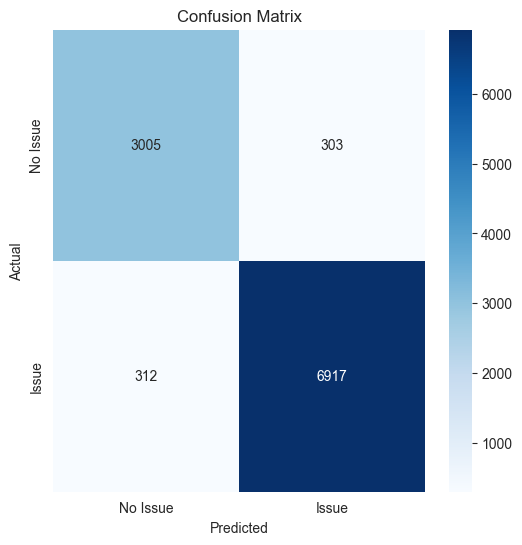

AUC Score: 0.9816
95% CI for AUC: [0.9795, 0.9837]


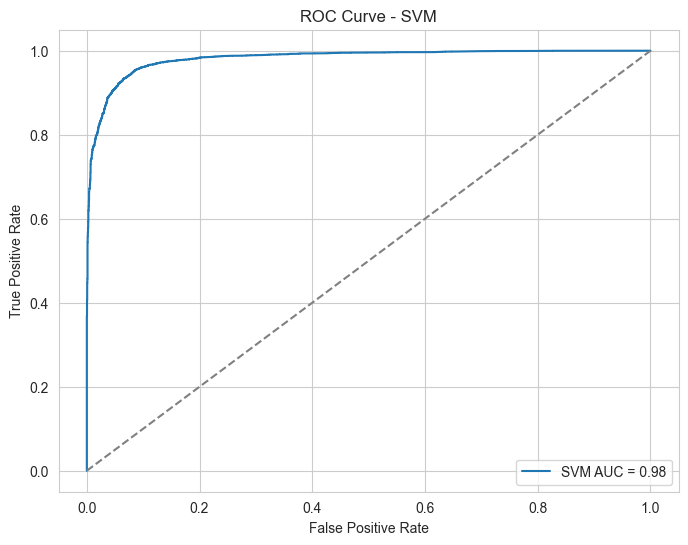

In [74]:
evaluate_model(SVM, x_test_new, y_new, model_name="SVM", use_proba=False)

### LR


--- Evaluation Report: LR ---

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3308
           1       0.95      0.95      0.95      7229

    accuracy                           0.94     10537
   macro avg       0.93      0.93      0.93     10537
weighted avg       0.94      0.94      0.94     10537

Weighted F1 Score: 0.9363
95% CI for F1 Score: [0.9318, 0.9413]


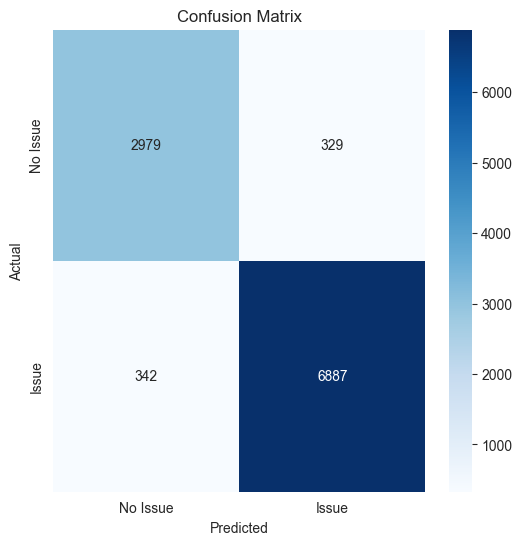

AUC Score: 0.9784
95% CI for AUC: [0.9759, 0.9807]


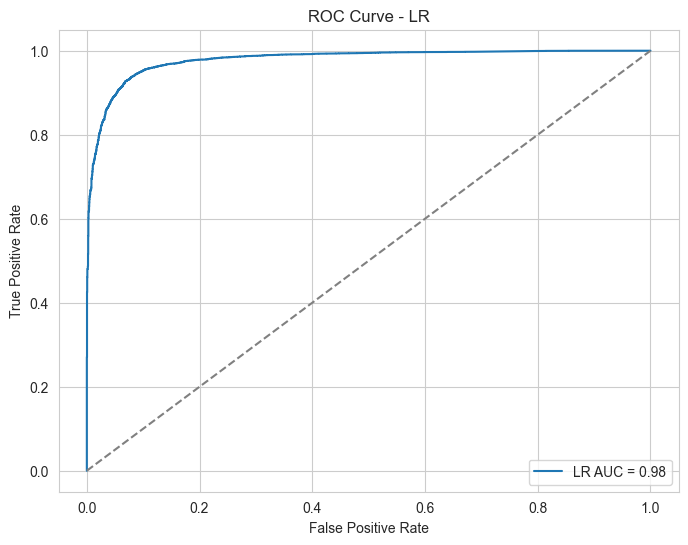

In [75]:
evaluate_model(LR, x_test_new, y_new, model_name="LR", use_proba=True)

### Random Forest


--- Evaluation Report: Random Forest ---

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      3308
           1       0.94      0.96      0.95      7229

    accuracy                           0.94     10537
   macro avg       0.93      0.92      0.92     10537
weighted avg       0.93      0.94      0.93     10537

Weighted F1 Score: 0.9348
95% CI for F1 Score: [0.9301, 0.9394]


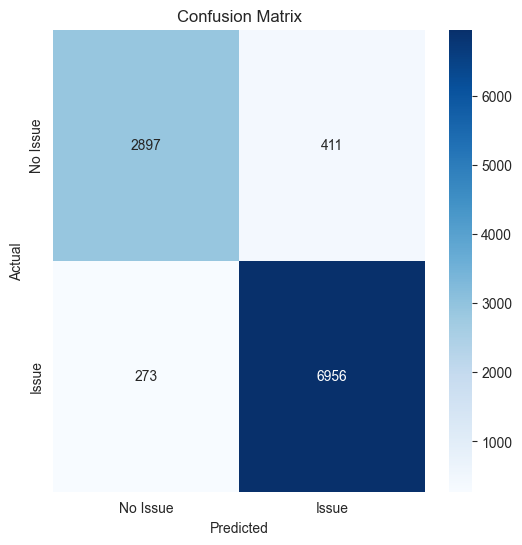

AUC Score: 0.9764
95% CI for AUC: [0.9735, 0.9791]


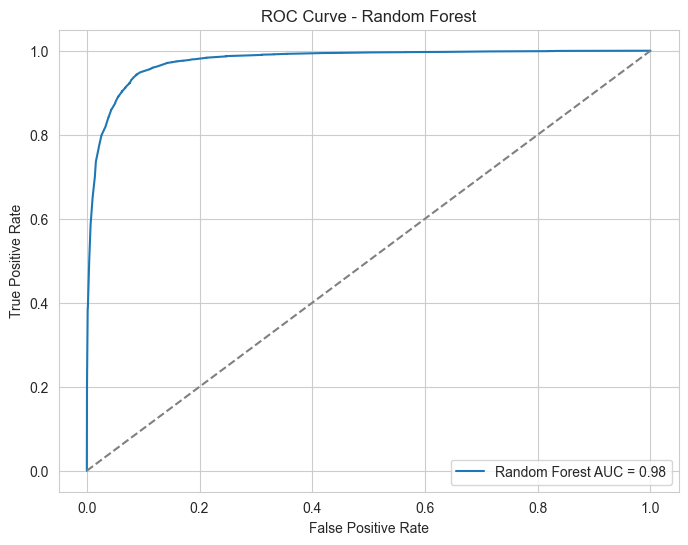

In [76]:
evaluate_model(RandomForest, x_test_new, y_new, model_name="Random Forest", use_proba=True)

### LGBM


--- Evaluation Report: LGBM ---

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3308
           1       0.95      0.95      0.95      7229

    accuracy                           0.94     10537
   macro avg       0.93      0.93      0.93     10537
weighted avg       0.94      0.94      0.94     10537

Weighted F1 Score: 0.9364
95% CI for F1 Score: [0.9313, 0.9410]


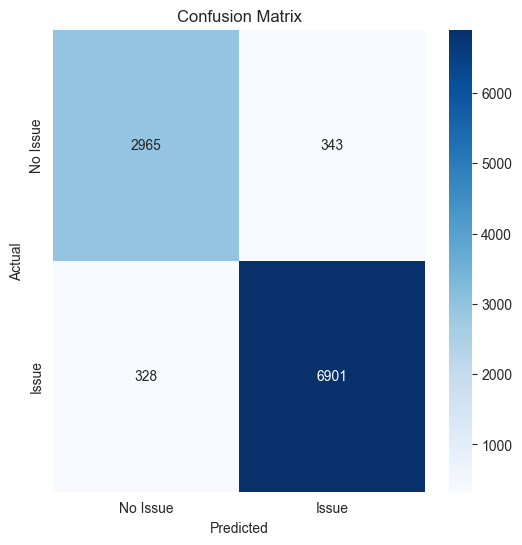

AUC Score: 0.9803
95% CI for AUC: [0.9779, 0.9826]


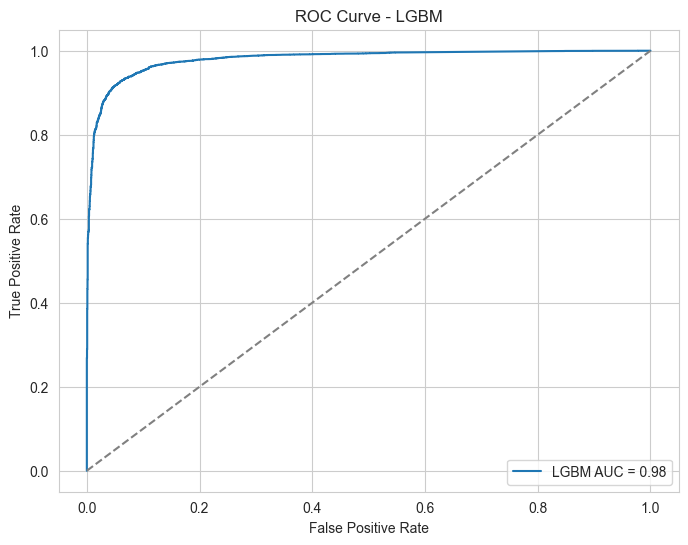

In [77]:
evaluate_model(LGBM, x_test_new, y_new, model_name="LGBM", use_proba=True)